In [1]:
#imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
#supporting functions
#function to display multiple images in subplots
def display_images(list_of_images,list_of_titles=None):
    N=len(list_of_images)
    M=int(np.ceil(N/2))
    figs,ax=plt.subplots(M,2,figsize=(12,12))
    ax=ax.flatten()
    for i in range(len(list_of_images)):
        ax[i].imshow(list_of_images[i],cmap='gray')
        if list_of_titles is not None:
            ax[i].title.set_text(list_of_titles[i])

    plt.show()

Problem with perceptron module is its input and output are binary 0 and 1. Hence a  change in any of the input may result in a complete flipping of 0 to 1 or vice versa. Which is not an ideal result for learning . 
What we want is for the module to have small change in output when small change in input is provided. Then the system would be able to learn from the data. 
Hence we will use another type of neuron called sigmoid neuron , whose inputs are not restricted to 0 and 1. 
sigmoid neuron takes any value between 0 and 1 as input and output is given by
$output\ = \ \sigma(wx+b) $

$ \sigma(z)=1/(1+e^{-z}) $

In [3]:
#function to define sigmoid neuron
def sigmoid(x):
    return 1/(1+np.exp(-x))

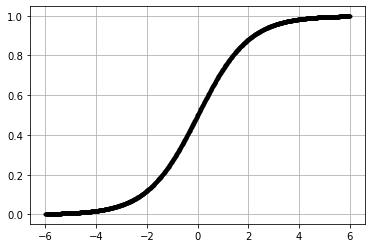

In [4]:
#plot the sigmoid output
x=np.linspace(-6,6,1000)
y=sigmoid(x)
plt.plot(x,y,'k.')
plt.grid()

As we can see from the above plot, the output curve is a smooth function as compared to the abrupt step function which was the case for perceptron. 
Now, we can create multiple layers of perceptron neurons to try to learn complex features than binary relationships. 


Next question arises: How the learning actually happens? it happens through an algorithm called gradient descent. We will implement gradient descent from first principle to see how it works. 

To achieve this, we will use MNIST dataset for training and testing the algorithms. MNIST dataset is a modified subsets of two data sets collected by NIST, the US National Institute of Standards and Technology. 
it has 60000 images to be used as training data and 10000 images to be used as test data. Each image is of 28 by 28 greyscale image. 

We denote x as a 28x28=784 dimensional vector. output y is denoted as a 10-dimensional vector, with only the index matching with desired output being 1 and rest being 0. so if output is 6, output vector would be $(0,0,0,0,0,0,1,0,0,0)^T$

Any training algorithm has three main components.

1. objective function / cost function / loss function
2. activation 
3. learning methodology 

in this case, we will use Mean Square Error (MSE) as the cost function, which can be defined as:

$ C(w,b)=\frac{1}{2n}\sum_{x}||y(x)-a||^2  $

where 

    n=number of training samples
    a=approximation of output from the network
    y(x) = output vector 
    w = all the weights in the network
    b = all the biases in the network

Gradient descent algorithm for this cost function is formulated as below:

   $ w_k \rightarrow w_k' = w_k - \eta\frac{ \partial C}{\delta w_k} $
   
   $ b_l \rightarrow b_l' = b_l - \eta\frac{ \partial C}{\delta b_l} $   


As we have to carry out these calculation for the entire dataset in repeated manner, the size of dataset may slow down the learning. Hence we adopt a process called mini batch gradient descent, where we sample a random set of m training inputs and update the weight and repeat till the entire dataset is exhausted. this one iteration is called one epoch.  This process sometimes is also called stochastic gradient descent. 

### Backpropagation algorithm derivation

Notations:
1. input layer is called layer 1 and further layers are named accordingly. number of layers = $L$
2. number of neurons in layer $l = d_l$
3. weight connecting $k^{th}$ neuron in $(l-1)^{th}$ layer to $j^{th}$ neuron in $l^{th}$ layer : $w_{jk}^l$
4. bias of $j^{th}$ neuron of layer $l : b_j^l$
5. There are two values associated with a neuron : linear combination value (denoted as $z_k^l$), activation (denoted as $a_k^l$)
6. $z^l = w^l * a^{l-1}+b^l$
7. $a^l = \sigma(z^l) $
8. objective = $C=\frac{1}{2}\sum_{j}||y_j-a_j^L||^2  $
9. Error at layer $l = \delta^l$


Equations of backpropagation
1. $\delta^L = \Delta_aC . \sigma'(z^L)$
2. $\delta^l = ((w^{l+1})^T \delta^{l+1}) . \sigma'(z^l) $
3. $\frac{\partial C}{\partial b_j^l} = \delta_j^l$
4. $\frac{\partial C}{\partial w_{jk}^l} = a_k^{l-1}\delta_j^l$

## Implementation

In [5]:
class Network:
    #initialize the network 
    #initialize the weights and biases
    def __init__(self,layers):
        self.num_layers=len(layers)
        self.layers=layers
        self.weights=[]
        self.biases=[]
        self.loss_history=[]
        self.accuracy_history=[]
        
        print("Network dimension: ",end=" ")
        for i in range(self.num_layers-1):
            w=np.random.randn(layers[i+1],layers[i])
            b=np.random.randn(layers[i+1],1)
            self.weights.append(w)
            self.biases.append(b)
            print("{} -".format(layers[i]),end=" ")
        print("{}".format(layers[-1]))

    # function to calculate sigmoid activation
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    #function to calculate derivative of sigmoid 
    def sigmoid_prime(self,x):
        z=self.sigmoid(x)
        return z*(1-z)
    
    #function to calculate feed forward
    def feedforward(self,x):
        for i in range(self.num_layers-1):
            z=np.dot(self.weights[i],x.T)+self.biases[i]
            x=self.sigmoid(z).T
        return x
    
    #function to calculate accuracy
    def calculate_accuracy(self,x,y):
        y_predicted=self.feedforward(x)
        correct=0
        total_datapoints=len(y)
        for i in range(total_datapoints):
            correct_label=np.argmax(y[i,:])
            predicted_label=np.argmax(y_predicted[i,:])
            if correct_label==predicted_label:
                correct +=1
        return (correct*100/total_datapoints)
        
    #function calculate loss 
    def calculate_loss(self,x,y):
        total_datapoints=len(y)
        y_predicted=self.feedforward(x)
        return np.mean((y_predicted-y)**2)
        
    #function to carry out SGD
    def SGD(self,train_x,train_y,epochs,mini_batch_size,lr,verbose=1):
        #steps involved:
        #step 1:sample mini batch size data from the training samples
        #step 2: calculate backpropagation and calculate gradients for weights and biases
        #step 3: update the weights and biases 
        
        number_of_data_points=len(train_x)
        for epoch in range(epochs):
            for k in range(0,number_of_data_points,mini_batch_size):
                k1=k//mini_batch_size
                x=train_x[k1*mini_batch_size:(k1+1)*mini_batch_size,:]
                y=train_y[k1*mini_batch_size:(k1+1)*mini_batch_size,:]
                self.update_mini_batch(x,y,lr)
            loss=self.calculate_loss(train_x,train_y)
            accuracy=self.calculate_accuracy(train_x,train_y)
            if verbose==1:
                print("[Update] epoch:{}, loss:{:.3f}, accuracy:{:.2f}".format(epoch+1,loss,accuracy))
            self.loss_history.append(loss)
            self.accuracy_history.append(accuracy)
        print("[Update] Accuracy after {} epochs:{:.2f}".format(epochs,accuracy))
        
    #function to update mini batch    
    def update_mini_batch(self,x,y,lr):
        #steps involved:
        #step 1: feedforward through the network 
        #step 2: calculate gradients
        #step 3: update the weights and biases


        activations=[x]
        activation=x
        delta_L=[]
        
        #feedforward through the network
        for i in range(self.num_layers-1):
            z=np.dot(self.weights[i],activation.T)+self.biases[i]
            activation=self.sigmoid(z).T
            activations.append(activation)
        
        #calculate errors for each layer
        for i in range(self.num_layers-1,0,-1):
            if i==self.num_layers-1:
                delta_l=(activations[-1]-y)*activations[-1]*(1-activations[-1])
                delta_L.append(delta_l)
            else:
#                 delta_l=(np.dot(delta_L[-1],self.weights[i]))*(activations[-i-1]*(1-activations[-i-1]))
                delta_l=(np.dot(delta_L[-1],self.weights[i]))*(activations[i]*(1-activations[i]))
                delta_L.append(delta_l)

        #calculate weight gradients and bias gradients
        for i in range(1,self.num_layers):
            dw=np.dot(delta_L[-i].T,activations[i-1])
            db=delta_L[-i].T
            self.weights[i-1] -= lr*dw
            self.biases[i-1] -= lr*np.mean(db,axis=1,keepdims=True)
    
    #plot the loss and accuracy history
    def plot_history(self):
        plt.subplot(1,2,1)
        plt.plot(self.loss_history,'k--')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        
        plt.subplot(1,2,2)
        plt.plot(self.accuracy_history,'k--')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
    
    #function to calculate test accuracy
    def test_accuracy(self,test_x,test_y):
        print("[Update] Test accuracy: {:.3f} %".format(self.calculate_accuracy(test_x,test_y)))
    

### Load the Mnist dataset and preprocess it

(60000, 785)


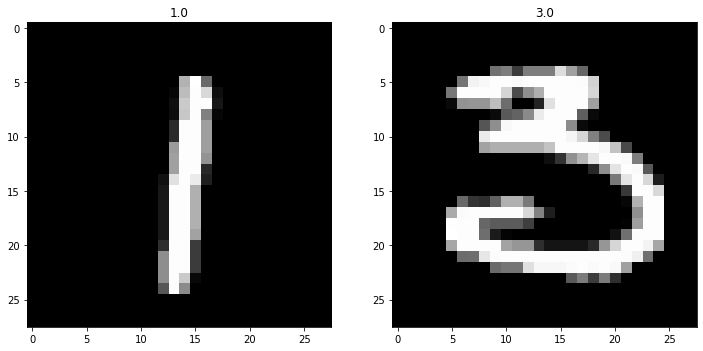

In [6]:
#load the mnist dataset as a pandas dataframe
mnist_train_data=pd.read_csv('mnist_train.csv').to_numpy().astype('float64')
print(mnist_train_data.shape)

#as we can see, the train data is having 60000x785 dimension.. i.e. 784 for 28x28 flattened image and 1 for output
#display two of images 
image1=mnist_train_data[40,1:].reshape(28,28)
label1=mnist_train_data[40,0]
image2=mnist_train_data[670,1:].reshape(28,28)
label2=mnist_train_data[670,0]
display_images([image1,image2],[str(label1),str(label2)])

#now normalize the training image and build the training dataset that will be 
# fed to the network
training_dataset=mnist_train_data.copy()
training_dataset[:,1:] /=255.0

#separate train_x and train_y and convert train_y to one hot labels
train_x=training_dataset[:,1:]
train_y=training_dataset[:,0]

labels=np.zeros((len(train_y),10))
for i in range(len(train_y)):
    labels[i,int(train_y[i])]=1




Network dimension:  784 - 30 - 10
[Update] epoch:1, loss:0.021, accuracy:87.13
[Update] epoch:2, loss:0.016, accuracy:90.42
[Update] epoch:3, loss:0.013, accuracy:91.86
[Update] epoch:4, loss:0.012, accuracy:92.62
[Update] epoch:5, loss:0.011, accuracy:93.21
[Update] epoch:6, loss:0.010, accuracy:93.69
[Update] epoch:7, loss:0.010, accuracy:94.06
[Update] epoch:8, loss:0.009, accuracy:94.36
[Update] epoch:9, loss:0.009, accuracy:94.56
[Update] epoch:10, loss:0.009, accuracy:94.72
[Update] epoch:11, loss:0.009, accuracy:94.89
[Update] epoch:12, loss:0.008, accuracy:95.01
[Update] epoch:13, loss:0.008, accuracy:95.10
[Update] epoch:14, loss:0.008, accuracy:95.17
[Update] epoch:15, loss:0.008, accuracy:95.29
[Update] epoch:16, loss:0.008, accuracy:95.35
[Update] epoch:17, loss:0.008, accuracy:95.46
[Update] epoch:18, loss:0.008, accuracy:95.54
[Update] epoch:19, loss:0.007, accuracy:95.61
[Update] epoch:20, loss:0.007, accuracy:95.68
[Update] epoch:21, loss:0.007, accuracy:95.75
[Update] 

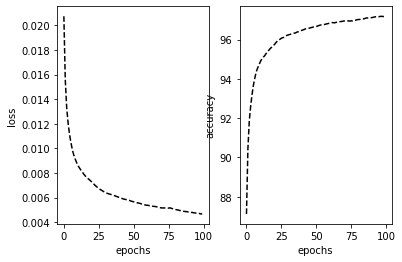

In [8]:
#build a network and train the model
net=Network([784,30,10])
net.SGD(train_x,labels,100,32,0.1,verbose=1)
net.plot_history()

In [9]:
#test the network on test dataset
mnist_test_data=pd.read_csv('mnist_test.csv').to_numpy().astype('float64')
print(mnist_test_data.shape)

#now normalize the training image and build the training dataset that will be 
# fed to the network
test_dataset=mnist_test_data.copy()
test_dataset[:,1:] /=255.0

#separate train_x and train_y and convert train_y to one hot labels
test_x=test_dataset[:,1:]
test_y=test_dataset[:,0]

labels=np.zeros((len(test_y),10))
for i in range(len(test_y)):
    labels[i,int(test_y[i])]=1

#check test set accuracy
net.test_accuracy(test_x,labels)

(10000, 785)
[Update] Test accuracy: 94.440 %
